In [1]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
from scipy.special import factorial as fact
import time
from scipy.linalg import expm, inv

cutoff = 9

In [2]:
def downMat(dim, order):    
    if order == 0:
        A = np.eye(dim)
        return A
    else:
        A = np.zeros([dim, dim])
        for i in np.arange(order, dim):
            A[i, i - order] = np.prod(np.sqrt(np.arange(i, i - order, -1)))
        return A

def upMat(dim, order):        
    if order == 0:
        A = np.eye(dim)
        return A
    else:
        A = np.zeros([dim, dim])
        for i in np.arange(0, dim - order):
            A[i, i + order] = np.prod(np.sqrt(np.arange(i + 1, i + 1 + order)))
        return A

def nMat(dim, order):
    if order == 0:
        A = np.eye(dim)
        return A
    else:
        A = np.diag(np.arange(dim) ** order)
        return A

In [3]:
def to_2d_ndarray(a):
    if isinstance(a,(np.ndarray)):
        return a
    else:
        return np.array([[a]])
    
def Sonin_vec(n, alpha, x):
    n = to_2d_ndarray(n)
    alpha = to_2d_ndarray(alpha)
    x = to_2d_ndarray(x)        
    N = np.max(n)
    a = special.factorial(n + alpha)
    S = np.zeros([N + 1, x.shape[0], x.shape[0], n.shape[0], n.shape[0]], dtype = "float64")
    for i in range(N + 1):
        if i == 0:
            S[0] = 1
        elif i == 1:
            I = np.where(n - i >= 0, 1, 0)
            I = I[np.newaxis, np.newaxis, :, :]
            I_bar = np.logical_not(I).astype("float64")
            S[1] = (alpha + 1 - x) * I + I_bar
        else:
            I = np.where(n - i >= 0, 1, 0)
            I = I[np.newaxis, np.newaxis, :, :].astype("float64")
            I_bar = np.logical_not(I).astype(int)
            res = (2 * i - 1 + alpha - x) * S[i - 1] - (i + alpha - 1) * S[i - 2]
            S[i] = res / i * I + S[i -1] * I_bar
    return S[N]

def FockWignerElement_vec(xmat, pmat, l, m):
    A = np.max(np.dstack([l, m]), axis=2)
    B = np.abs(l - m)
    C = np.min(np.dstack([l, m]), axis=2)
    xmat = xmat[:, :, np.newaxis, np.newaxis]
    pmat = pmat[:, :, np.newaxis, np.newaxis]
    R = xmat**2 + pmat**2
    X = xmat + np.sign(l-m) * 1j * pmat
    W = 2 * (-1)**C * np.sqrt(2**(B) * special.factorial(C) / special.factorial(A)) * X**(B) * np.exp(-R)
    S = Sonin_vec(C, B, 2 * R)
    return W * S

## Multi mode化

prepare multi mode Fock state

In [4]:
modeNum = 3
cutoff = 9
def vacuumState(modeNum, cutoff):
    fockState = np.zeros([(cutoff + 1) ** modeNum])
    fockState[0] = 1
    return fockState.reshape([cutoff + 1] * modeNum)

In [5]:
def singleGate_preProcess(fockState, mode):
    cutoff = fockState.shape[-1] - 1
    fockState = np.swapaxes(fockState, mode, fockState.ndim - 1)
    return fockState.reshape(-1, cutoff + 1)

def twoModeGate_preProcess(fockState, mode1, mode2):
    cutoff = fockState.shape[-1] - 1
    fockState = np.swapaxes(fockState, mode2, modeNum - 1)
    fockState = np.swapaxes(fockState, mode1, modeNum - 2)
    return fockState.reshape(-1, cutoff + 1, cutoff + 1)

def singleGate_postProcess(fockState, mode, modeNum):
    cutoff = fockState.shape[-1] - 1
    fockState = fockState.reshape([cutoff + 1] * modeNum)
    return np.swapaxes(fockState, mode, modeNum - 1)

def twoModeGate_postProcess(fockState, mode1, mode2, modeNum):
    cutoff = fockState.shape[-1] - 1
    fockState = fockState.reshape([cutoff + 1] * modeNum)
    fockState = np.swapaxes(fockState, mode1, modeNum - 2)
    fockState = np.swapaxes(fockState, mode2, modeNum - 1)
    return fockState

In [6]:
def exp_annihirationMat(fockState, alpha, order = 1, cutoff = 10):
    row = fockState.shape[0]
    mat = downMat(fockState.shape[-1], order)
    mat_ = np.empty(mat.shape, dtype=np.complex)
    mat_ = expm(alpha * mat)
    res = np.dot(fockState, mat_)
    return res

def exp_creationMat(fockState, alpha, order = 1, cutoff = 10):
    row = fockState.shape[0]
    mat = upMat(fockState.shape[-1], order)
    mat_ = np.empty(mat.shape, dtype=np.complex)
    mat_ = expm(alpha * mat)
    res = np.dot(fockState, mat_)
    return res

def exp_photonNumMat(fockState, alpha, order = 1, cutoff = 10):
    row = fockState.shape[0]
    mat = nMat(fockState.shape[-1], order)
    mat_ = np.empty(mat.shape, dtype=np.complex)
    mat_ = expm(alpha * mat)
    res = np.dot(fockState, mat_)
    return res

In [7]:
def reduceState(fockState, mode):
    modeNum = fockState.ndim
    cutoff = fockState.shape[-1] - 1
    fockState = np.swapaxes(fockState, mode, 0)
    fockState = fockState.flatten()
    rho = np.outer(np.conj(fockState), fockState)
    for i in range(modeNum - 1):
        rho = partialTrace(rho, cutoff)
    return  rho

def partialTrace(rho, cutoff):
    split = np.int(rho.shape[-1] / (cutoff + 1))
    rho = np.array(np.split(rho, split, axis = -1))
    rho = np.array(np.split(rho, split, axis = -2))
    rho = np.trace(rho, axis1 = -2, axis2 = -1)
    return  rho

In [8]:
def displacement(fockState, mode, alpha, cutoff):
    modeNum = fockState.ndim
    state = singleGate_preProcess(fockState, mode)
    state = exp_annihirationMat(state, -np.conj(alpha), cutoff = cutoff)
    state = exp_creationMat(state, alpha, cutoff = cutoff)
    state = singleGate_postProcess(state, mode, modeNum)
    return state * np.exp(-np.abs(alpha)**2 / 2)

### 試してみる

In [9]:
alpha1 = (- 1 + 1j)
mode1 = 1
alpha2 = (1 - 1j)
mode2 = 2
modeNum = 3
cutoff = 10
fockState = vacuumState(modeNum, cutoff)
state = displacement(fockState, mode1, alpha1, cutoff)
state = displacement(state, mode2, alpha2, cutoff)
# reducedState0 = reduceState(state, 0)
# reducedState1 = reduceState(state, 1)
# reducedState2 = reduceState(state, 2)

# print(reducedState0)
# print(reducedState1)
# print(reducedState2)

In [10]:
def FockWigner_vec(xmat, pmat, fockState, mode, tol=1e-10):
    if fockState.ndim < mode + 1:
        raise  ValueError("The mode is not exist.")
    if fockState.ndim > 1:
        rho = reduceState(fockState, mode)
    else:
        rho = np.outer(np.conj(fockState), fockState)
    dim = len(fockState)
    grid = np.indices([dim, dim])
    W = FockWignerElement_vec(xmat, pmat, grid[0], grid[1])
    W = rho * W
    W = np.sum(np.sum(W, axis = -1), axis = -1)
    if np.max(np.imag(W)) < tol:
        W = np.real(W)
    else:
        raise ValueError("Wigner plot has imaginary value.")
    return W

0.30841970443725586


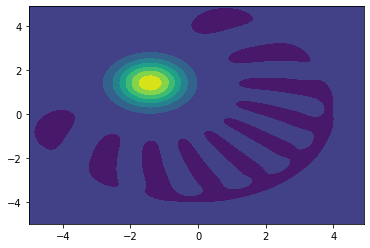

In [11]:
x = np.arange(-5, 5, 0.1)
p = np.arange(-5, 5, 0.1)
m = len(x)
xx, pp = np.meshgrid(x, p)
xi_array = np.dstack((pp, xx))
start = time.time()
        
W = FockWigner_vec(xx, pp, state, 1)

h = plt.contourf(x, p, W)
t = time.time() - start
print(t)

### Beam Splitter

$\hat{H} = i\hbar \theta (\hat{a}_{1}^{\dagger}\hat{a}_{2} -\hat{a}_{1}  \hat{a}_{2}^{\dagger})$

$BSgate = \exp(\frac{i}{\hbar}\hat{H})$

In [12]:
A = np.arange(27).reshape(3, 3, 3)
A.reshape(-1, 9)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23, 24, 25, 26]])

In [48]:
def twoModeGate_preProcess2(fockState, mode1, mode2):
    cutoff = fockState.shape[-1] - 1
    modeNum = fockState.ndim
    fockState = np.swapaxes(fockState, mode2, modeNum - 1)
    fockState = np.swapaxes(fockState, mode1, modeNum - 2)
    return fockState.reshape(-1, (cutoff + 1) ** 2)

def twoModeGate_postProcess2(fockState, mode1, mode2, modeNum):
    dim = np.int(np.sqrt(fockState.shape[-1]))
    fockState = fockState.reshape([dim] * modeNum)
    fockState = np.swapaxes(fockState, mode1, modeNum - 2)
    fockState = np.swapaxes(fockState, mode2, modeNum - 1)
    return fockState

In [49]:
def ab_ba(fockState, cutoff):
    state = np.zeros(fockState.shape) + 0j
    dim = cutoff + 1
    a = np.arange(dim) * np.ones([dim, dim])
    ind1 = np.ravel(a, order = 'F').astype(np.int)
    ind2 = np.ravel(a, order = 'K').astype(np.int)
    coef =  fockState[:, ind1, ind2]
    down1 = down(1, ind1)
    up2 = up(1, ind2, cutoff)
    state[:, down1[1], up2[1]] -= down1[0] * up2[0] * coef

    up1 = up(1, ind1, cutoff)
    down2 = down(1, ind2)
    state[:, up1[1], down2[1]] += up1[0] * down2[0] * coef
    return state

def pow_ab_ba(fockState, n, cutoff):
    state = np.copy(fockState)
    if n == 0:
        return state
    else:
        for i in range(n):
            state = ab_ba(state, cutoff)
        return state

def exp_BS(fockState, alpha, cutoff):
    state = np.zeros(fockState.shape) + 0j
    for i in range(2 * cutoff + 1): # order
        tmpstate = np.copy(fockState)
        tmpstate = pow_ab_ba(tmpstate, i, cutoff)
        tmpstate = tmpstate / special.factorial([i]) * alpha ** i
        state += tmpstate
    return state

In [50]:
def exp_BSMat(fockState, alpha, cutoff):
    state = np.zeros(fockState.shape) + 0j
    down = downMat(cutoff + 1, 1)
    up = upMat(cutoff + 1, 1)
    mat1_ = np.dot(mat_for_mode1(up), mat_for_mode2(down))
    mat2_ = np.dot(mat_for_mode1(down), mat_for_mode2(up))
    mat_ = mat1_ - mat2_
    emat_ = expm(alpha * mat_)
    res = np.dot(fockState, emat_)
    return res

def mat_for_mode2(mat):
    l = mat.shape[0]
    mat_ = np.zeros(np.array(mat.shape)**2)
    for i in range(mat.shape[0]):
        mat_[i*l:i*l+l, i*l:i*l+l] = mat
    return mat_

def mat_for_mode1(mat):
    l = mat.shape[0]
    mat_ = np.zeros(np.array(mat.shape)**2)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[0]):
            mat_[i*l:i*l+l, j*l:j*l+l] = np.eye(l) * mat[i, j]
    return mat_

def BSmat(fockState, mode1, mode2, theta, cutoff):
    modeNum = fockState.ndim
    if modeNum < 2:
        raise ValueError("The gate requires more than one mode.")
    state = twoModeGate_preProcess2(fockState, mode1, mode2)
    state = exp_BSMat(state, -theta, cutoff)
    state = twoModeGate_postProcess2(state, mode1, mode2, modeNum)
    return state

In [51]:
def BS(fockState, mode1, mode2, theta, cutoff):
    modeNum = fockState.ndim
    if modeNum < 2:
        raise ValueError("The gate requires more than one mode.")
    state = twoModeGate_preProcess(fockState, mode1, mode2)
    state = exp_BS(state, -theta, cutoff)
    state = twoModeGate_postProcess(state, mode1, mode2, modeNum)
    return state

In [62]:
alpha = (1 + 1j)
mode = 2
modeNum = 3
cutoff = 15
start = time.time()
state = vacuumState(modeNum, cutoff)
state = displacement(state, mode, alpha, cutoff)
print(np.sum(np.abs(state)**2))
state2 = BSmat(state, 1, 2, np.pi / 4, cutoff)
print(np.sum(np.abs(state2)**2))
t = time.time() - start
print(t)

0.9999999995200304
0.9999999995200297
0.04891204833984375


1.3115589618682861


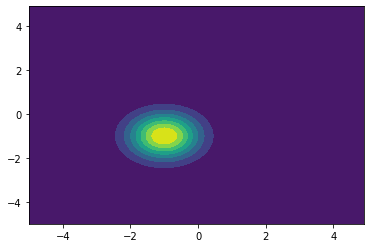

In [66]:
x = np.arange(-5, 5, 0.1)
p = np.arange(-5, 5, 0.1)
m = len(x)
xx, pp = np.meshgrid(x, p)
xi_array = np.dstack((pp, xx))
start = time.time()
        
W1 = FockWigner_vec(xx, pp, state2, 1)

h = plt.contourf(x, p, W1)
t = time.time() - start
print(t)

## For Check

In [26]:
import sys
sys.path.append('../')

import photonqat as pq
import strawberryfields as sf
from strawberryfields.ops import *

In [27]:
G = pq.Gaussian(3)
#G.Displace(0, alpha) # Displacement gate, x to x+2
G.Displace(2, alpha) # Displacement gate, x to x+2
G.BS(1, 2, -np.pi/4) # 50:50 beam splitter

print('mu0 =', G.mean(0))
print('mu1 =', G.mean(1))
print('mu2 =', G.mean(2))

mu0 = [0. 0.]
mu1 = [1. 1.]
mu2 = [1. 1.]


In [28]:
eng = sf.Engine(backend="gaussian")
gaussian = sf.Program(3)

with gaussian.context as q:
        sf.hbar = 1
        # prepare the initial states
        Dgate(alpha) | q[2] # displacement gate
        BSgate(-np.pi/4, 0) | (q[1], q[2])  # 50-50 beamsplitter


results = eng.run(gaussian)
mu0, cov0 = results.state.reduced_gaussian([0])
mu1, cov1 = results.state.reduced_gaussian([1])
mu2, cov2 = results.state.reduced_gaussian([2])
print('mu0 =', mu0)
print('mu1 =', mu1)
print('mu2 =', mu2)

mu0 = [0. 0.]
mu1 = [1. 1.]
mu2 = [1. 1.]


Generate beamsplitter factors in the Fock basis.

This function generates the beamsplitter prefactors,

$ prefac_{N,n,M,m,k} = (-1)^{N-k}\sqrt{binom(n,k)binom(m,N-k)binom(N,k)binom(M,n-k)}$

for a specific cutoff dimension $D$.

Note that the last dimension will only contain non-zero values
for indices $0$ to $n$

Args:
D (int): generate prefactors for $D$ dimensions.